In [2]:
%load_ext autoreload
%autoreload 2

import torch
from matplotlib import pyplot as plt
from text3d2video.attention_utils import (
    extended_attn_kv_hidden_states,
)

In [3]:
from einops import rearrange

from visual_tests.testing_utils import test_img

n_frames = 6
chunk_size = 2
resolution = 64


def make_test_img(txt: str, color):
    return test_img(txt, resolution=resolution, color=color, return_type="pt")


frames_cond = [make_test_img(str(i), "lightgray") for i in range(n_frames)]
frames_uncond = [make_test_img(str(i), "black") for i in range(n_frames)]

chunked_images = torch.cat(
    [torch.stack(frames_cond), torch.stack(frames_uncond)], dim=0
)
x = rearrange(chunked_images, "b c h w -> b (h w) c")

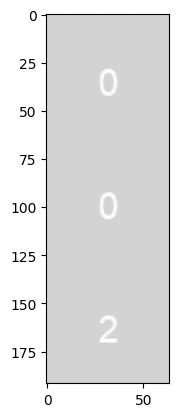

In [4]:
x_kv = extended_attn_kv_hidden_states(x, frame_indices=[0, 0, 2])

x_kv_square = rearrange(x_kv, "b (h w) c -> b c h w", w=resolution)
plt.imshow(x_kv_square[0].permute(1, 2, 0))

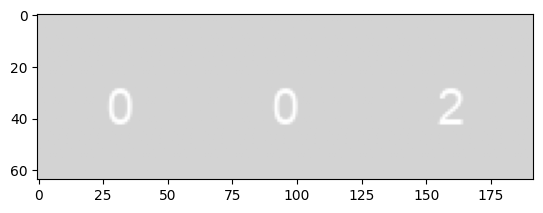

In [11]:
x_kv = extended_attn_kv_hidden_states(x, frame_indices=[0, 0, 2])

x_kv_square = rearrange(x_kv, "b (n h w) c -> b c h (n w)", w=resolution, h=resolution)


plt.imshow(x_kv_square[0].permute(1, 2, 0))

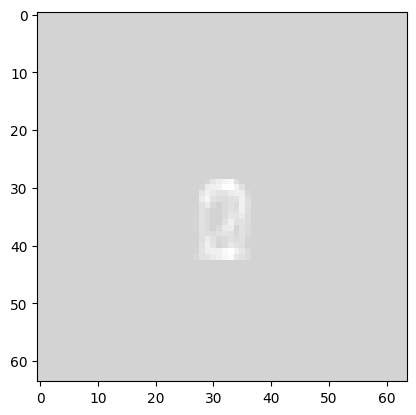

In [12]:
from text3d2video.attention_utils import averaged_attn_kv_hidden_states


x_kv = averaged_attn_kv_hidden_states(x, frame_indices=[0, 1, 2])

x_kv_square = rearrange(x_kv, "b (h w) c -> b c h w", w=resolution)
plt.imshow(x_kv_square[0].permute(1, 2, 0))